In [7]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sanknn/facemask-detection")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/facemask-detection


Found 8118 images belonging to 2 classes.
Found 1822 images belonging to 2 classes.
Found 1809 images belonging to 2 classes.
Epoch 1/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 39s 137ms/step - accuracy: 0.7561 - loss: 0.4895 - val_accuracy: 0.9243 - val_loss: 0.2009
Epoch 2/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 35s 133ms/step - accuracy: 0.9022 - loss: 0.2487 - val_accuracy: 0.9270 - val_loss: 0.1853
Epoch 3/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 34s 130ms/step - accuracy: 0.9182 - loss: 0.2102 - val_accuracy: 0.9385 - val_loss: 0.1499
Epoch 4/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - accuracy: 0.9351 - loss: 0.1750 - val_accuracy: 0.9566 - val_loss: 0.1055
Epoch 5/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 36s 139ms/step - accuracy: 0.9407 - loss: 0.1554 - val_accuracy: 0.9676 - val_loss: 0.0808
Epoch 6/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 36s 138ms/step - accuracy: 0.9453 - loss: 0.1384 - val_accuracy: 0.9715 - val_loss: 0.0687
Epoch 7/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 36s 139ms/step - accuracy: 0.9554 - loss: 0.1227

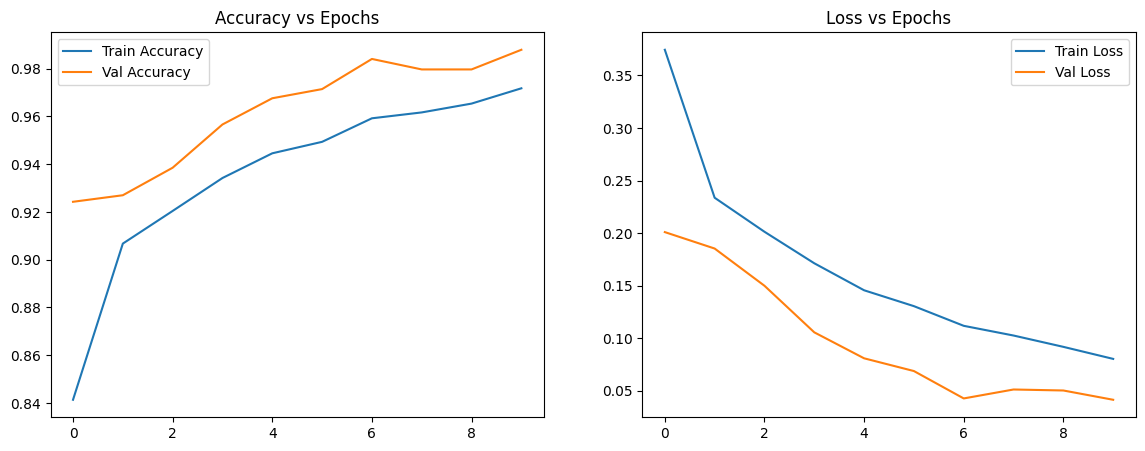

57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 114ms/step

Classification Report:

              precision    recall  f1-score   support

   With_mask       0.99      0.93      0.96       849
Without_mask       0.94      1.00      0.97       960

    accuracy                           0.96      1809
   macro avg       0.97      0.96      0.96      1809
weighted avg       0.97      0.96      0.96      1809



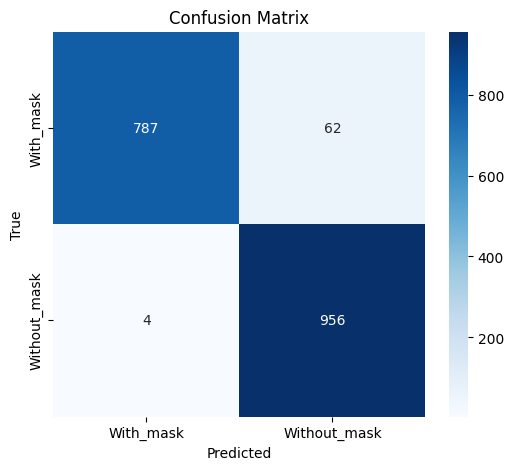

In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import joblib

# Set paths
base_path = "/kaggle/input/facemask-detection/Facemaskdetection"
train_path = os.path.join(base_path, "train")
val_path = os.path.join(base_path, "val")
test_path = os.path.join(base_path, "test")

# Output folder
output_dir = "./cnn_results"
os.makedirs(output_dir, exist_ok=True)

# Image preprocessing
img_size = (128, 128)
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_path, target_size=img_size, batch_size=batch_size, class_mode='binary'
)
val_gen = val_datagen.flow_from_directory(
    val_path, target_size=img_size, batch_size=batch_size, class_mode='binary'
)
test_gen = test_datagen.flow_from_directory(
    test_path, target_size=img_size, batch_size=batch_size, class_mode='binary', shuffle=False
)

# CNN model from scratch
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_gen, validation_data=val_gen, epochs=10)

# Save model
model.save(os.path.join(output_dir, "cnn_facemask_model.h5"))

# Save accuracy and loss curves
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Val Accuracy")
plt.title("Accuracy vs Epochs")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.title("Loss vs Epochs")
plt.legend()
plt.savefig(os.path.join(output_dir, "cnn_accuracy_loss.png"))
plt.show()

# Evaluate on test set
test_preds = (model.predict(test_gen) > 0.5).astype("int32")
y_true = test_gen.classes
y_pred = test_preds.flatten()

# Save classification report
report = classification_report(y_true, y_pred, target_names=test_gen.class_indices.keys())
with open(os.path.join(output_dir, "cnn_classification_report.txt"), "w") as f:
    f.write(report)

print("\nClassification Report:\n")
print(report)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=test_gen.class_indices.keys(), 
            yticklabels=test_gen.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig(os.path.join(output_dir, "cnn_confusion_matrix.png"))
plt.show()

Found 8118 images belonging to 2 classes.
Found 1822 images belonging to 2 classes.
Found 1809 images belonging to 2 classes.
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 68/254 ━━━━━━━━━━━━━━━━━━━━ 1:11 384ms/step - accuracy: 0.4742 - loss: 0.9668

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


254/254 ━━━━━━━━━━━━━━━━━━━━ 123s 438ms/step - accuracy: 0.5908 - loss: 0.7538 - val_accuracy: 0.9144 - val_loss: 0.3469
Epoch 2/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 107s 408ms/step - accuracy: 0.9220 - loss: 0.2745 - val_accuracy: 0.9506 - val_loss: 0.2207
Epoch 3/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 107s 409ms/step - accuracy: 0.9538 - loss: 0.1773 - val_accuracy: 0.9621 - val_loss: 0.1672
Epoch 4/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 107s 410ms/step - accuracy: 0.9612 - loss: 0.1399 - val_accuracy: 0.9660 - val_loss: 0.1413
Epoch 5/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 108s 413ms/step - accuracy: 0.9716 - loss: 0.1084 - val_accuracy: 0.9671 - val_loss: 0.1264
Epoch 6/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 107s 409ms/step - accuracy: 0.9727 - loss: 0.0974 - val_accuracy: 0.9665 - val_loss: 0.1179
Epoch 7/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 108s 414ms/step - accuracy: 0.9786 - loss: 0.0846 - val_accuracy: 0.9715 - val_loss: 0.1032
Epoch 8/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 107s 410ms/step - accuracy: 0.9763 - loss: 0.08

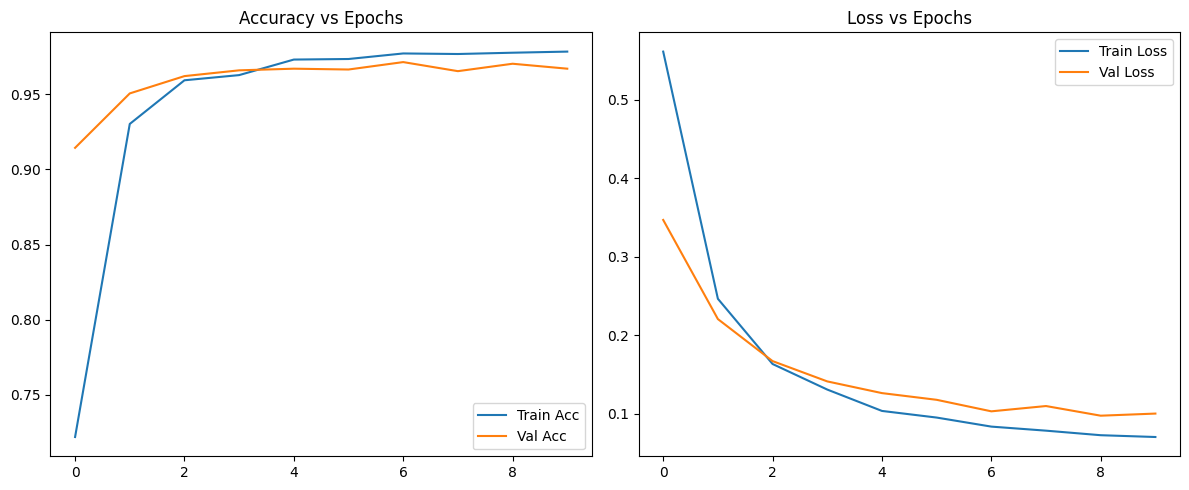

1809/1809 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step
Classification Report:
               precision    recall  f1-score   support

   With_mask       0.79      1.00      0.88       849
Without_mask       1.00      0.77      0.87       960

    accuracy                           0.88      1809
   macro avg       0.89      0.88      0.88      1809
weighted avg       0.90      0.88      0.88      1809



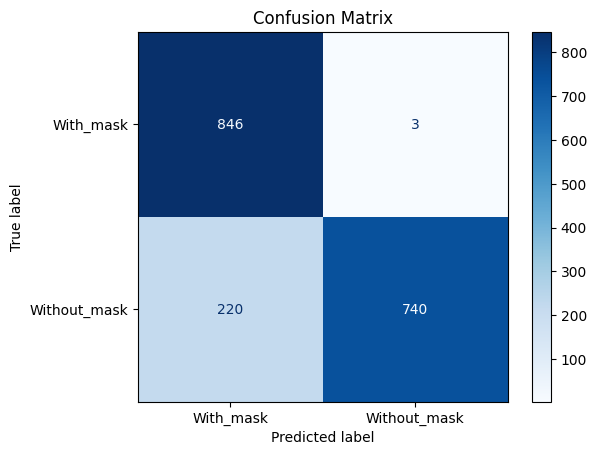

In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Directories
base_dir = "/kaggle/input/facemask-detection/Facemaskdetection"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

# Output directory
output_dir = "./mobilenetv2_results"
os.makedirs(output_dir, exist_ok=True)

# Image generators
img_size = 224
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, rotation_range=10)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(train_dir, target_size=(img_size, img_size),
                                              batch_size=batch_size, class_mode='binary')
val_gen = val_test_datagen.flow_from_directory(val_dir, target_size=(img_size, img_size),
                                               batch_size=batch_size, class_mode='binary')
test_gen = val_test_datagen.flow_from_directory(test_dir, target_size=(img_size, img_size),
                                                batch_size=1, class_mode='binary', shuffle=False)

# MobileNetV2 model
base_model = MobileNetV2(input_shape=(img_size, img_size, 3), include_top=False, weights='imagenet')
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base model
for layer in base_model.layers:
    layer.trainable = False

# Compile
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train
history = model.fit(train_gen, epochs=10, validation_data=val_gen)

# Save model
model.save(os.path.join(output_dir, "mobilenetv2_facemask_model.h5"))

# Plot and save accuracy/loss curves
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy vs Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss vs Epochs")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "mobilenetv2_accuracy_loss.png"))
plt.show()

# Classification report
y_true = test_gen.classes
y_pred = (model.predict(test_gen) > 0.5).astype("int32").flatten()

report = classification_report(y_true, y_pred, target_names=test_gen.class_indices.keys())
print("Classification Report:\n", report)

with open(os.path.join(output_dir, "mobilenetv2_classification_report.txt"), "w") as f:
    f.write(report)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_gen.class_indices.keys())
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.savefig(os.path.join(output_dir, "mobilenetv2_confusion_matrix.png"))
plt.show()

Found 8118 images belonging to 2 classes.
Found 1822 images belonging to 2 classes.
Found 1809 images belonging to 2 classes.
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 27/254 ━━━━━━━━━━━━━━━━━━━━ 1:28 389ms/step - accuracy: 0.5210 - loss: 0.7515

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


254/254 ━━━━━━━━━━━━━━━━━━━━ 128s 447ms/step - accuracy: 0.5073 - loss: 0.7464 - val_accuracy: 0.5768 - val_loss: 0.6865
Epoch 2/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 109s 417ms/step - accuracy: 0.5040 - loss: 0.7253 - val_accuracy: 0.6240 - val_loss: 0.6843
Epoch 3/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 108s 415ms/step - accuracy: 0.5206 - loss: 0.7108 - val_accuracy: 0.6471 - val_loss: 0.6824
Epoch 4/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 109s 418ms/step - accuracy: 0.5272 - loss: 0.7018 - val_accuracy: 0.5434 - val_loss: 0.6810
Epoch 5/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 109s 418ms/step - accuracy: 0.5371 - loss: 0.6917 - val_accuracy: 0.5159 - val_loss: 0.6814
Epoch 6/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 110s 420ms/step - accuracy: 0.5522 - loss: 0.6829 - val_accuracy: 0.5582 - val_loss: 0.6778
Epoch 7/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 108s 414ms/step - accuracy: 0.5525 - loss: 0.6820 - val_accuracy: 0.5812 - val_loss: 0.6763
Epoch 8/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 107s 409ms/step - accuracy: 0.5577 - loss: 0.68

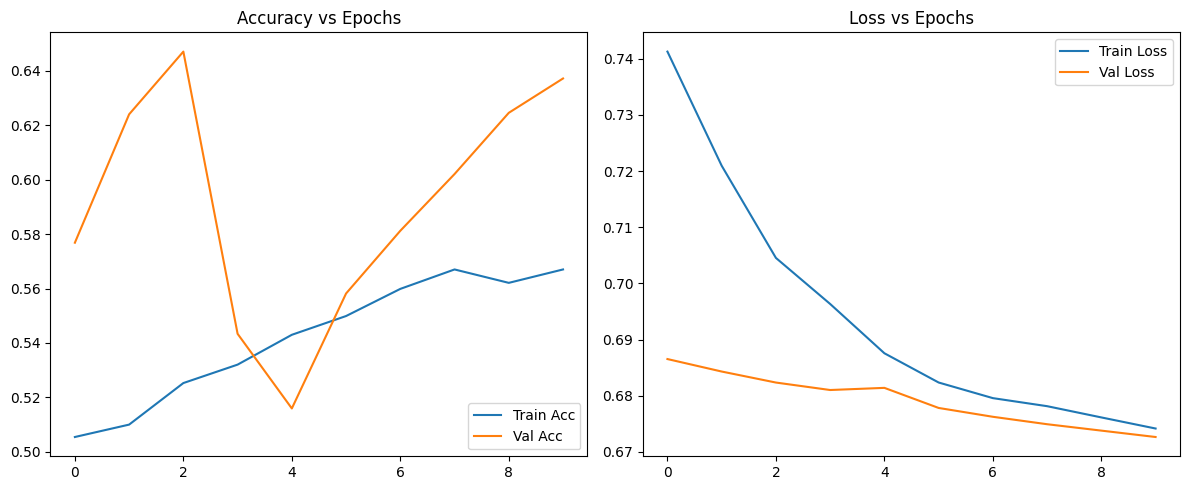

1809/1809 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step
Classification Report:
               precision    recall  f1-score   support

   With_mask       0.71      0.66      0.68       849
Without_mask       0.72      0.77      0.74       960

    accuracy                           0.71      1809
   macro avg       0.71      0.71      0.71      1809
weighted avg       0.71      0.71      0.71      1809



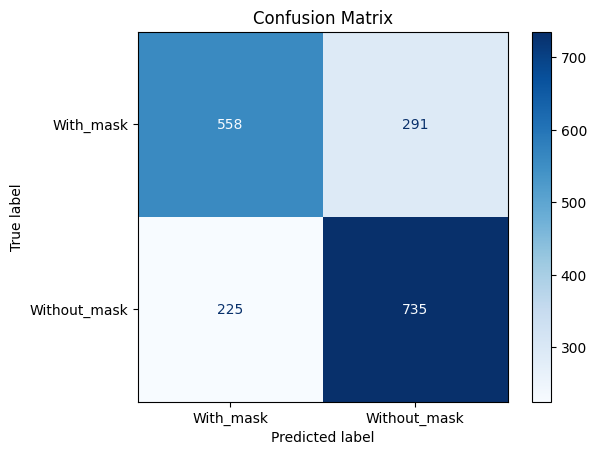

In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Directories
base_dir = "/kaggle/input/facemask-detection/Facemaskdetection"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

# Output directory
output_dir = "./resnet50_results"
os.makedirs(output_dir, exist_ok=True)

# Image generators
img_size = 224
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, rotation_range=10)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(train_dir, target_size=(img_size, img_size),
                                              batch_size=batch_size, class_mode='binary')
val_gen = val_test_datagen.flow_from_directory(val_dir, target_size=(img_size, img_size),
                                               batch_size=batch_size, class_mode='binary')
test_gen = val_test_datagen.flow_from_directory(test_dir, target_size=(img_size, img_size),
                                                batch_size=1, class_mode='binary', shuffle=False)

# ResNet50 model
base_model = ResNet50(input_shape=(img_size, img_size, 3), include_top=False, weights='imagenet')
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base model
for layer in base_model.layers:
    layer.trainable = False

# Compile
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train
history = model.fit(train_gen, epochs=10, validation_data=val_gen)

# Save model
model.save(os.path.join(output_dir, "resnet50_facemask_model.h5"))

# Plot and save accuracy/loss curves
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy vs Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss vs Epochs")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "resnet50_accuracy_loss.png"))
plt.show()

# Classification report
y_true = test_gen.classes
y_pred = (model.predict(test_gen) > 0.5).astype("int32").flatten()

report = classification_report(y_true, y_pred, target_names=test_gen.class_indices.keys())
print("Classification Report:\n", report)

with open(os.path.join(output_dir, "resnet50_classification_report.txt"), "w") as f:
    f.write(report)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_gen.class_indices.keys())
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.savefig(os.path.join(output_dir, "resnet50_confusion_matrix.png"))
plt.show()

Found 1809 images belonging to 2 classes.
Found 1809 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1809/1809 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step
1809/1809 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step
1809/1809 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5621 - loss: 0.5830 - val_accuracy: 1.0000 - val_loss: 0.2733
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8729 - loss: 0.4890 - val_accuracy: 1.0000 - val_loss: 0.2242
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9458 - loss: 0.4105 - val_accuracy: 1.0000 - val_loss: 0.1798
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9695 - loss: 0.3449 - val_accuracy: 1.0000 - val_loss: 0.1500
Epoch 5/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9603 - loss: 0.3182 - val_accuracy: 1.0000 - val_loss: 0.1243
Epoch 6/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9611 - loss: 0.2674 - val_accuracy: 1.0000 - val_loss: 0.1058
Epoch 7/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9541 - loss: 0.2473 - val_accuracy: 1.0000 - val_loss: 0.0918
Epoch 8/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9563 - loss: 0.2299 - val_accuracy: 1.0000 - val_loss: 0.0821
Ep

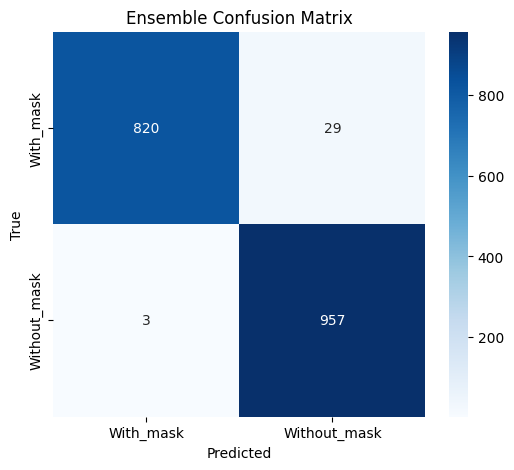

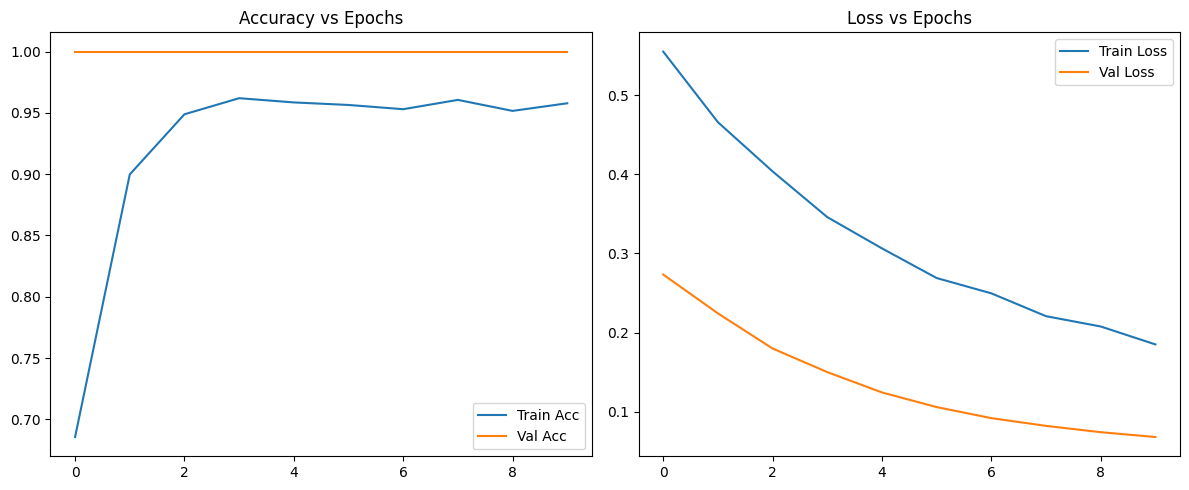

In [11]:
import numpy as np
import os
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Directories
test_dir = "/kaggle/input/facemask-detection/Facemaskdetection/test"
batch_size = 32
img_size_cnn = (128, 128)
img_size_other = (224, 224)

# Load test data for all models
datagen = ImageDataGenerator(rescale=1./255)

# CNN model input shape
test_gen_cnn = datagen.flow_from_directory(
    test_dir, target_size=img_size_cnn, batch_size=1,
    class_mode='binary', shuffle=False)

# MobileNetV2 / ResNet50 input shape
test_gen_224 = datagen.flow_from_directory(
    test_dir, target_size=img_size_other, batch_size=1,
    class_mode='binary', shuffle=False)

# Load models
cnn_model = load_model("/kaggle/working/cnn_results/cnn_facemask_model.h5")
mobilenet_model = load_model("/kaggle/working/mobilenetv2_results/mobilenetv2_facemask_model.h5")
resnet_model = load_model("/kaggle/working/resnet50_results/resnet50_facemask_model.h5")

# Get predictions (softmax/sigmoid outputs)
cnn_preds = cnn_model.predict(test_gen_cnn)
mobilenet_preds = mobilenet_model.predict(test_gen_224)
resnet_preds = resnet_model.predict(test_gen_224)

# Stack predictions as features for meta-learner
X_meta = np.concatenate([cnn_preds, mobilenet_preds, resnet_preds], axis=1)
y_true = test_gen_cnn.classes

# Meta-learner
meta_model = Sequential([
    Dense(8, activation='relu', input_shape=(3,)),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

meta_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the meta-learner
history = meta_model.fit(X_meta, y_true, epochs=10, batch_size=16, validation_split=0.2)

# Evaluate
ensemble_preds = (meta_model.predict(X_meta) > 0.5).astype("int32").flatten()
report = classification_report(y_true, ensemble_preds, target_names=test_gen_cnn.class_indices.keys())
print("\nClassification Report:\n", report)

# Save report
ensemble_dir = "/kaggle/working/ensemble_results"
os.makedirs(ensemble_dir, exist_ok=True)
with open(os.path.join(ensemble_dir, "ensemble_classification_report.txt"), "w") as f:
    f.write(report)

# Confusion matrix
cm = confusion_matrix(y_true, ensemble_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_gen_cnn.class_indices.keys(),
            yticklabels=test_gen_cnn.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Ensemble Confusion Matrix")
plt.savefig(os.path.join(ensemble_dir, "ensemble_confusion_matrix.png"))
plt.show()

# Accuracy and loss curves
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="Train Acc")
plt.plot(history.history['val_accuracy'], label="Val Acc")
plt.title("Accuracy vs Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.title("Loss vs Epochs")
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(ensemble_dir, "ensemble_accuracy_loss.png"))
plt.show()